In [1]:
import flopy
import flopy.mf6 as mf6
import flopy.plot as fplt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

import findwells as fw

After running the simulation, the outputs are saved to the output files directory. Luckily, you don't need to recreate and run the simulation every time you would like to visualize the outputs. 

Simply load in the simulation and grab the model objects, then retrieve the outputs from the model object!

## Load Simulation

In [2]:
# Load Simulation
sim = mf6.MFSimulation.load(sim_name='peterson', exe_name='../../mf6/mf6.exe', sim_ws='../input-files/')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package wel...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package ist...
    loading package mst...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading packag

## Load Models

In [3]:
# Grab groundwater flow model from simulation
gwf = sim.get_model('peterson_flow')

# Grab transport model for each solute
gwt_pfos = sim.get_model('peterson_pfos')
gwt_pfoa = sim.get_model('peterson_pfoa')
gwt_pfhxs = sim.get_model('peterson_pfhxs')

## Visualizing Head Data

In [4]:
# read head outputs from model object
head_obj = gwf.output.head()

# Load data from final timestep
heads = head_obj.get_data()

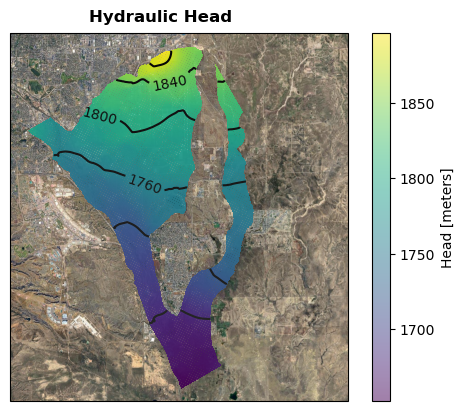

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,4), )#dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

vmax = heads[heads!=1e30].max()
vmin = heads[heads!=1e30].min()
cellhead = modelmap.plot_array(heads[0], ax=ax, cmap='viridis', 
                               transform=ccrs.UTM(13), alpha=0.5)
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

contour = modelmap.contour_array(heads[0], ax=ax, vmin=0,
                                 transform=ccrs.UTM(13), cmap='Grays')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')
ax.clabel(contour)

plt.suptitle('Hydraulic Head', weight='bold')
plt.show()

## Plot Flooded Cells

In [6]:
# Load in top elevation of layer
top_elev = np.loadtxt('../input-files/data-files/dis-top-elev.dat')

# Take difference between top elevation and head
diff = top_elev - heads[0]
diff_neg = np.where(diff < 0, diff, np.nan)  # Grab negative values (head > top)

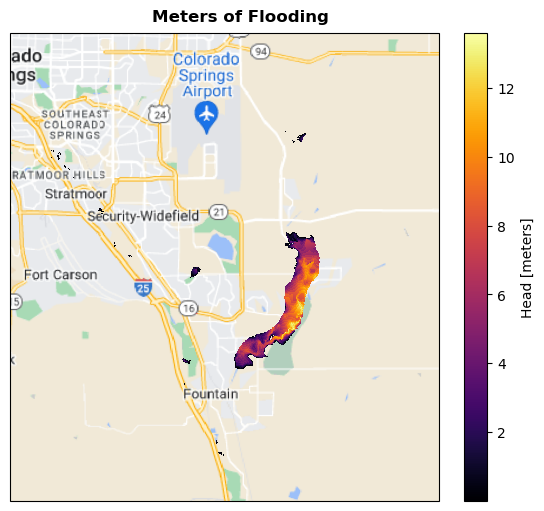

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,5))#, dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

cellhead = modelmap.plot_array(-diff_neg, ax=ax, cmap='inferno', transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

ggtiles = GoogleTiles()
ax.add_image(ggtiles, 11)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')

plt.suptitle('Meters of Flooding', weight='bold')
# plt.savefig('../figures/flooded-cells.png', bbox_inches='tight')
plt.show()

## Plot Observed vs Simulated Heads

In [6]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/head_obs.csv', isBinary=False)
sim_df = obs_out.get_dataframe()

In [7]:
# Set time index
sim_df.set_index('totim', inplace=True)
sim_df.head()

# Remove duplicate columns by keeping the first occurrence
sim_df = sim_df.loc[:, ~sim_df.columns.duplicated()]
sim_df.head()

FOUNTAINNO.1  SC01406518ACDT02-MW006  SC01406518CAAMW1-1  \
totim                                                             
59.0    1682.075674             1885.561179         1880.741585   
89.0    1681.985069             1885.564890         1880.754346   
274.0   1681.889633             1885.574850         1880.770702   
304.0   1681.816338             1885.570968         1880.757883   
365.0   1681.725386             1885.563764         1880.732140   

       SC01406519ABDT04-MW004  SC01406519BBBT01-MW002  SC01406520CDBMW2-4  \
totim                                                                       
59.0              1850.117363             1868.071535         1827.990993   
89.0              1850.183835             1868.098124         1828.208374   
274.0             1850.356906             1868.076726         1828.940524   
304.0             1850.337479             1868.040005         1828.986603   
365.0             1850.316800             1867.966637         1829.066861   

       SC01406527ACB1  SC01406527DDB1BANNING-LEWISRANCHES  SC01406527DDB2  \
totim                                                                       
59.0      1819.616543                         1811.984183     1809.927091   
89.0      1819.783271                         1812.083547     1810.069314   
274.0     1819.809110                         1812.556186     1810.684332   
304.0     1819.819301                         1812.580050     1810.728021   
365.0     1819.830034                         1812.638065     1810.809124   

       SC01406527DDC1  ...  SCO1506602BBBTH-18  SCO1506602BDC  SCO1506602CAA  \
totim                  ...                                                     
59.0      1807.807486  ...         1775.289597    1766.734205    1765.286099   
89.0      1807.925113  ...         1775.249922    1766.733054    1765.288777   
274.0     1808.575962  ...         1774.818713    1766.540752    1765.245674   
304.0     1808.628498  ...         1774.769802    1766.516540    1765.236956   
365.0     1808.722987  ...         1774.621564    1766.445214    1765.212130   

       SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AABTH-49  \
totim                                                                    
59.0     1769.092320    1761.914484    1763.967126         1762.170914   
89.0     1769.082253    1761.880545    1763.729539         1762.471178   
274.0    1768.771646    1761.593404    1763.396315         1762.402868   
304.0    1768.744202    1761.541243    1763.343999         1762.390026   
365.0    1768.636281    1761.435515    1763.254933         1762.368499   

       SCO1506604ABA2TH-50  SCO1506610BAA  SCO1506611ABCTH-47  
totim                                                          
59.0           1762.210882    1749.552483         1748.704047  
89.0           1762.553016    1749.553336         1748.704152  
274.0          1762.508143    1749.551632         1748.708031  
304.0          1762.499393    1749.548157         1748.708644  
365.0          1762.484772    1749.543681         1748.708939  

[5 rows x 149 columns]

In [16]:
obs_df = pd.read_csv('../input-files/data-files/flow-observed-heads.csv', index_col='time')
obs_df.head()

FOUNTAINNO.1  SC01406518ACDT02-MW006  SC01406518CAAMW1-1  \
time                                                             
59             NaN                     NaN                 NaN   
89             NaN                     NaN                 NaN   
454            NaN                     NaN                 NaN   
639            NaN                     NaN                 NaN   
789            NaN                     NaN                 NaN   

      SC01406519ABDT04-MW004  SC01406519BBBT01-MW002  SC01406520CDBMW2-4  \
time                                                                       
59                       NaN                     NaN                 NaN   
89                       NaN                     NaN                 NaN   
454                      NaN                     NaN                 NaN   
639                      NaN                     NaN                 NaN   
789                      NaN                     NaN                 NaN   

      SC01406527ACB1  SC01406527DDB1BANNING-LEWISRANCHES  SC01406527DDB2  \
time                                                                       
59               NaN                                 NaN             NaN   
89               NaN                                 NaN             NaN   
454              NaN                                 NaN             NaN   
639              NaN                                 NaN             NaN   
789              NaN                                 NaN     1802.757888   

      SC01406527DDC1  ...  SCO1506602BBBTH-18  SCO1506602BDC  SCO1506602CAA  \
time                  ...                                                     
59               NaN  ...                 NaN            NaN            NaN   
89               NaN  ...                 NaN            NaN            NaN   
454              NaN  ...                 NaN            NaN            NaN   
639              NaN  ...                 NaN            NaN            NaN   
789      1803.123648  ...                 NaN            NaN            NaN   

      SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AABTH-49  \
time                                                                    
59              NaN            NaN            NaN                 NaN   
89              NaN            NaN            NaN                 NaN   
454             NaN            NaN            NaN                 NaN   
639             NaN            NaN            NaN                 NaN   
789             NaN            NaN            NaN                 NaN   

      SCO1506604ABA2TH-50  SCO1506610BAA  SCO1506611ABCTH-47  
time                                                          
59                    NaN            NaN                 NaN  
89                    NaN            NaN                 NaN  
454                   NaN            NaN                 NaN  
639                   NaN            NaN                 NaN  
789                   NaN            NaN                 NaN  

[5 rows x 149 columns]

In [14]:
# Align sim_df and obs_df by their common indices
common_index = sim_df.index.intersection(obs_df.index)

# Use only the rows corresponding to the common index
sim_df_aligned = sim_df.loc[common_index]
obs_df_aligned = obs_df.loc[common_index]

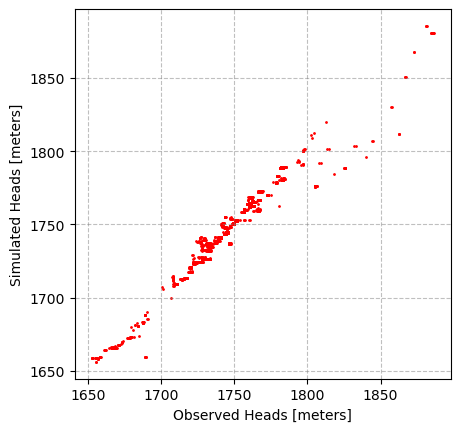

In [15]:
fig, ax = plt.subplots()

for col in sim_df.columns:
    if (col != 'SC01506614BBA TH-5') & (col != 'SC01606516CCC2'):
        ax.scatter(obs_df_aligned[col], sim_df_aligned[col], color='r', s=1)

    else:
        print(f"Well {col} not in both")

ax.set_xlabel('Observed Heads [meters]')
ax.set_ylabel('Simulated Heads [meters]')
ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

## Plot Concentration Results

### PFOS Results

In [17]:
# Get solute concentrations
PFOS = gwt_pfos.output.concentration().get_alldata()
PFOA = gwt_pfoa.output.concentration().get_alldata()
PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [18]:
PFOS.shape, PFOA.shape, PFHxS.shape

((446, 1, 972, 700), (446, 1, 972, 700), (446, 1, 972, 700))

In [19]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOS')

In [24]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

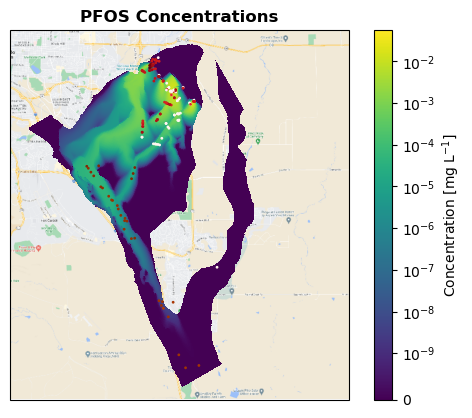

In [25]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)})

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFOS[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)



ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

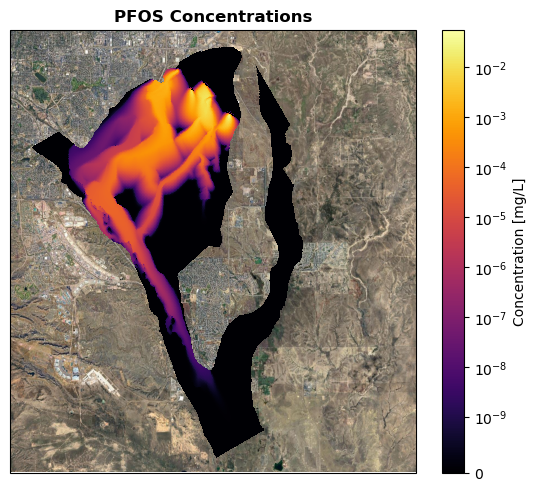

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOS concentration

Day of sampling since model start: `17713`

In [27]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [28]:
obs_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv', index_col='Well Name')
obs_wells = obs_wells.T

In [29]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOS (ng/L)"]

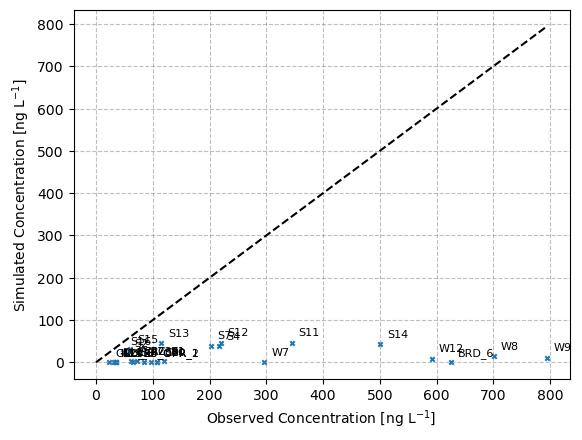

In [30]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, s=10, marker='x')
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [31]:
pfos_us = pd.read_csv('../input-files/data-files/tran-PFOS-observations.csv')

In [32]:
pfos_us['SDate'] = pd.to_datetime(pfos_us.SDate)

In [33]:
pfos_us.set_index('SDate', inplace=True)

In [34]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [35]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [36]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL-1 not in both
Well WELL-3 not in both
Well WELL-4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSSOUTH not in both


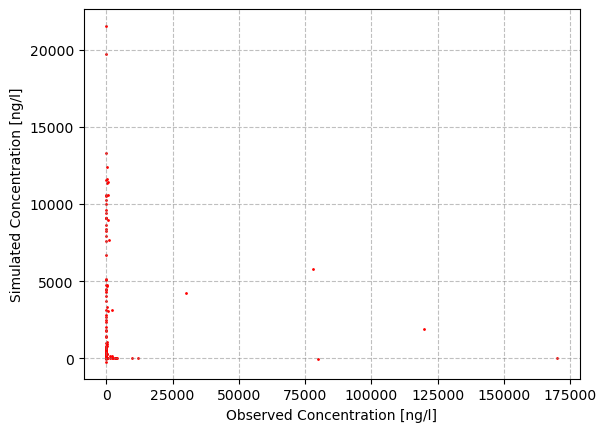

In [37]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfos_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)
        well_names = pfos_us.columns  # Extract well names from the column headers
        
    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFOA Results

In [38]:
PFOA.shape

(446, 1, 972, 700)

In [39]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOA')

In [41]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

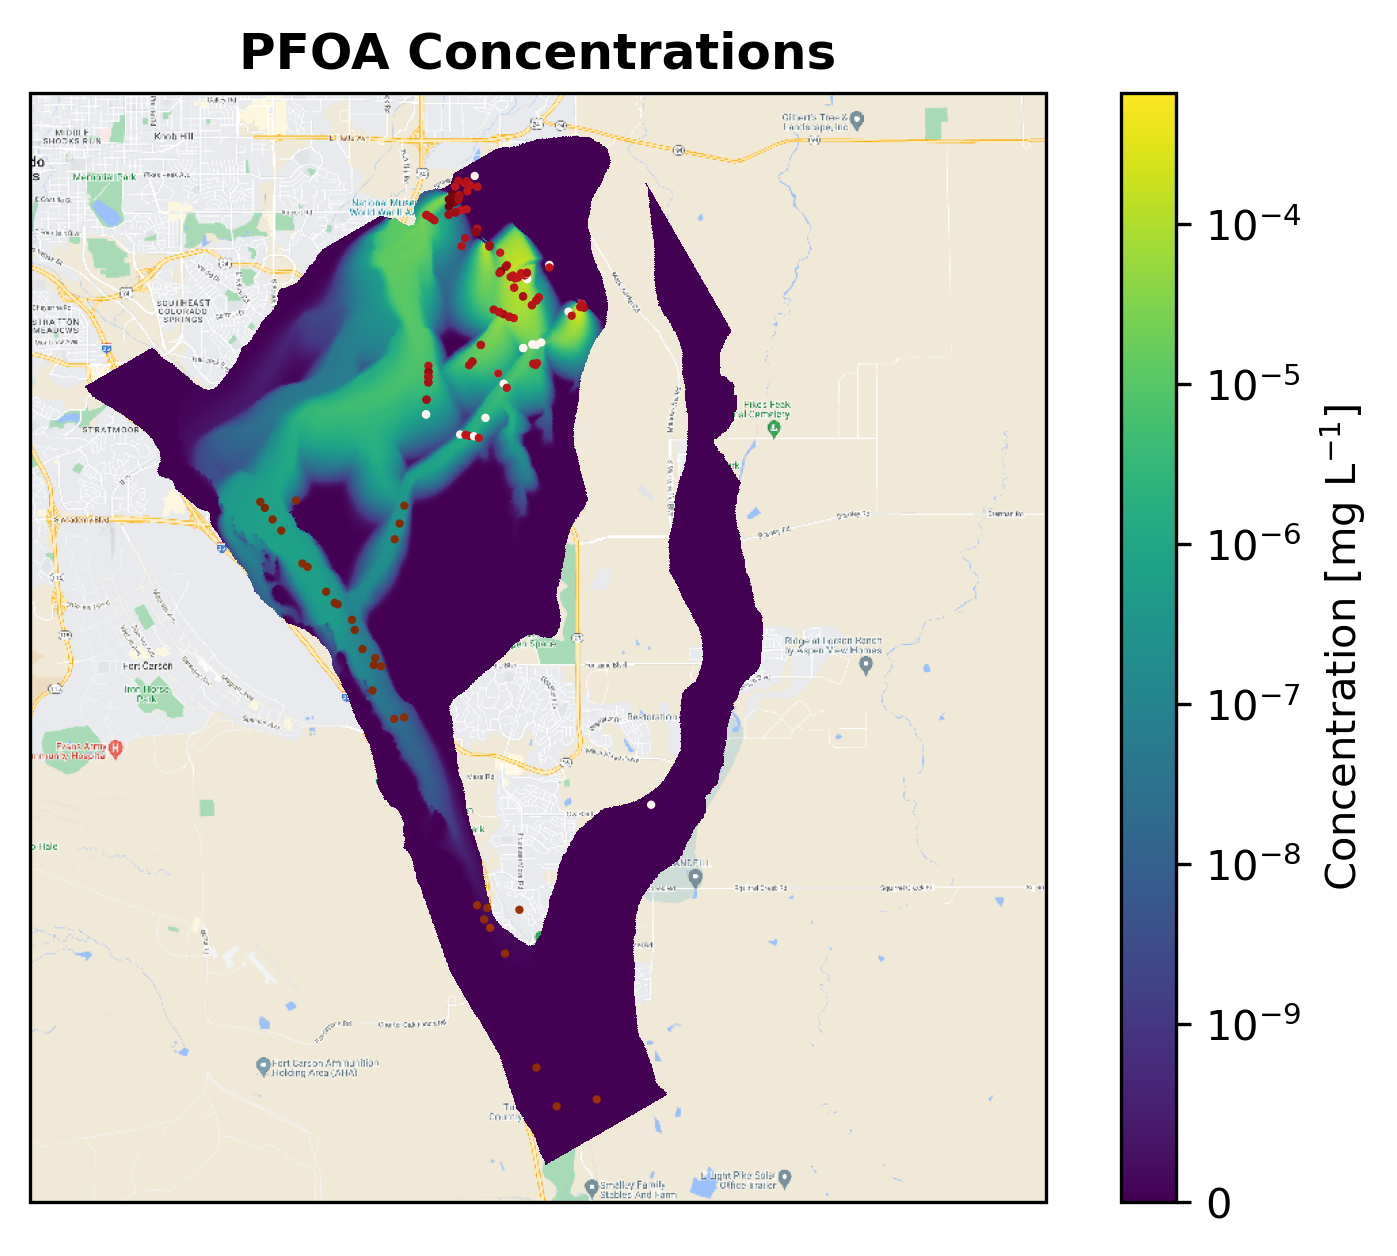

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfoa)

vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFOA[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOA (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

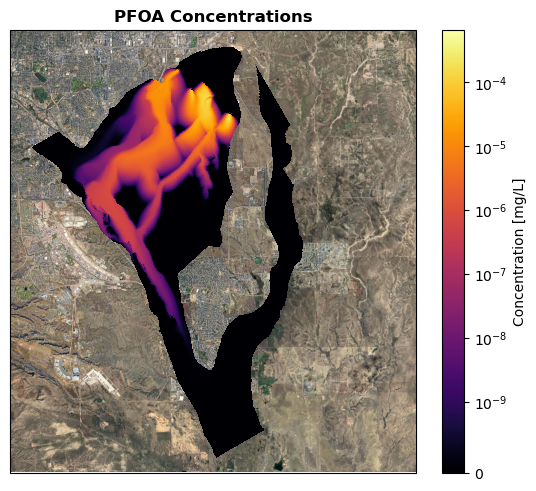

In [43]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOA
vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOA[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOA concentration

In [44]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [45]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOA (ng/L)"]

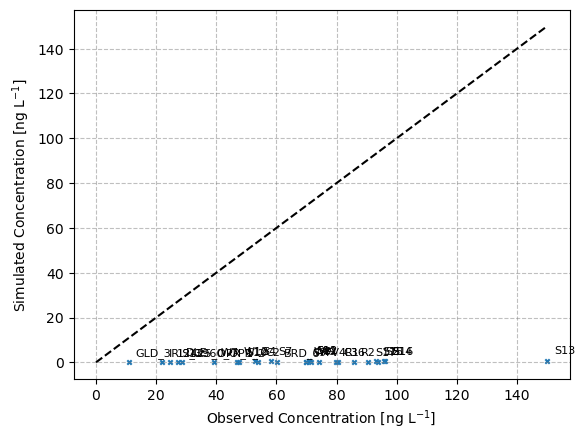

In [46]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, marker='x', s=10)
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [48]:
pfoa_us = pd.read_csv('../input-files/data-files/tran-PFOA-observations.csv')

pfoa_us['SDate'] = pd.to_datetime(pfoa_us.SDate)

pfoa_us.set_index('SDate', inplace=True)

In [49]:
# Not confident this cell needs to be in again
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [50]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [51]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL-1 not in both
Well WELL-3 not in both
Well WELL-4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

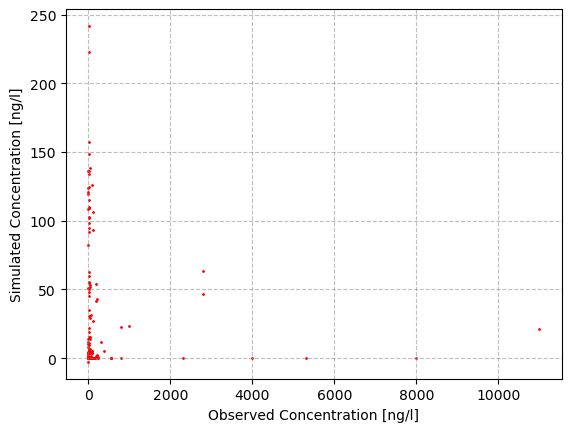

In [52]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfoa_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFHxS Results

In [53]:
PFHxS.shape

(446, 1, 972, 700)

In [54]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFHxS')

In [56]:
x = gwt_pfhxs.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfhxs.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

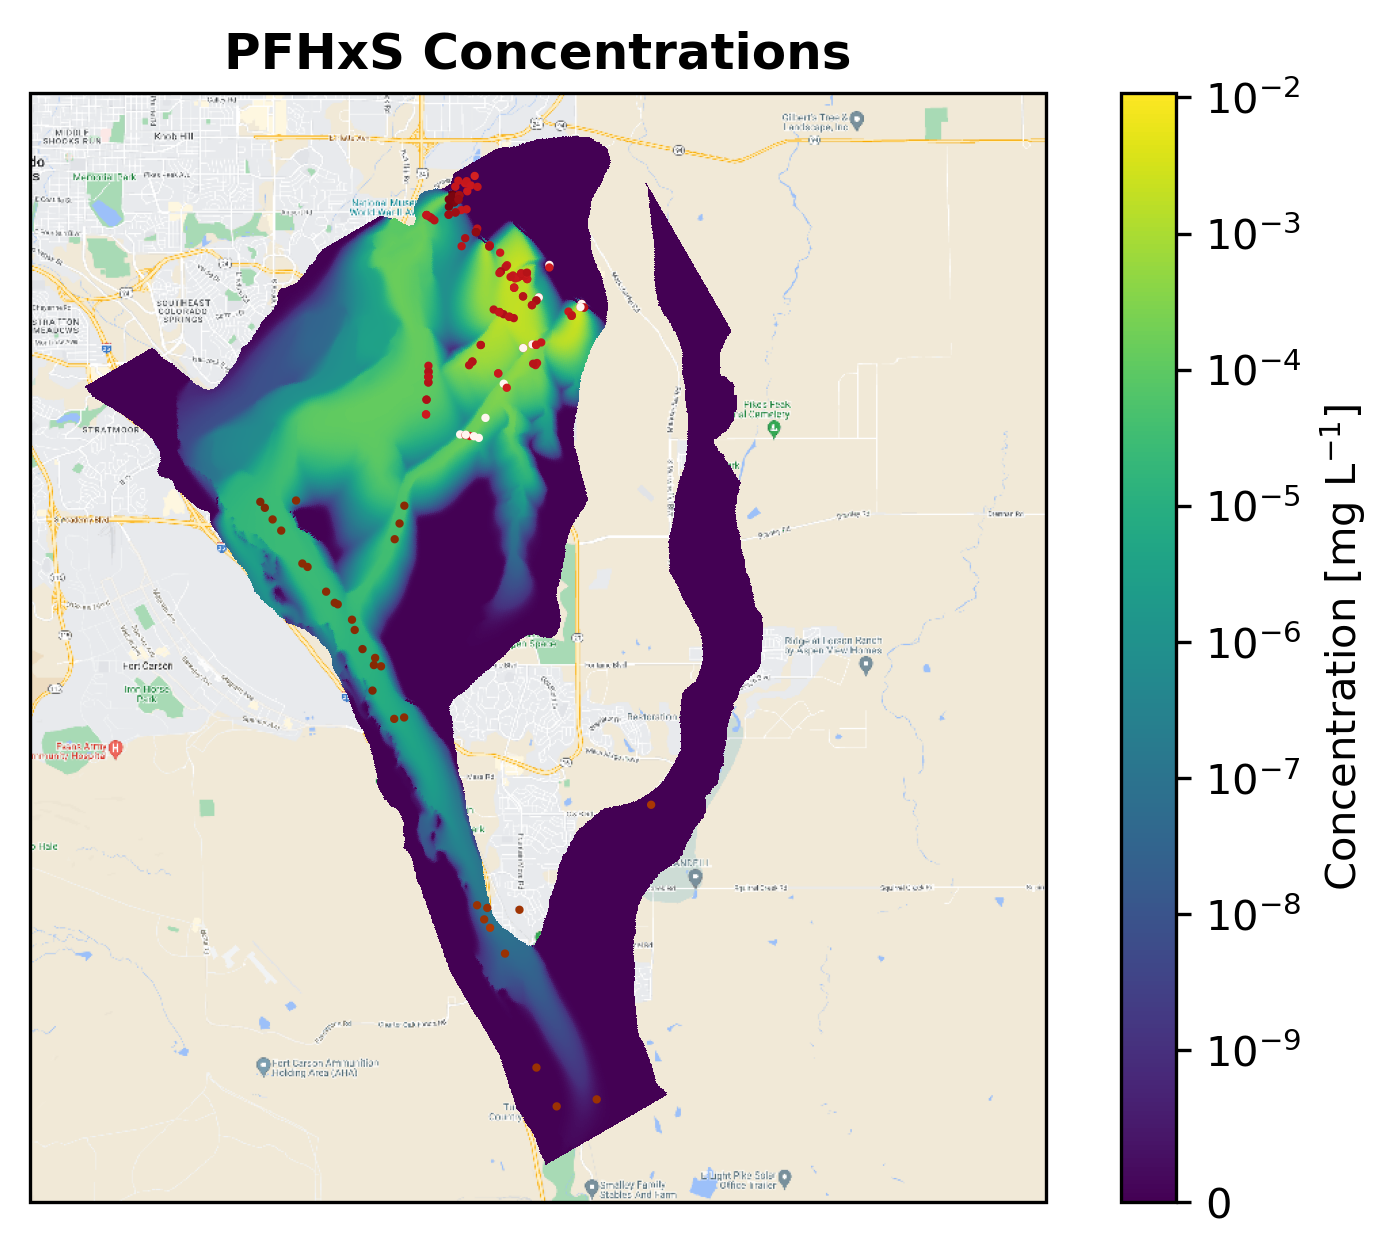

In [57]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFHxS[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

# cs1 = modelmap.plot_array(k, transform=ccrs.UTM(13))
# fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFHxS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

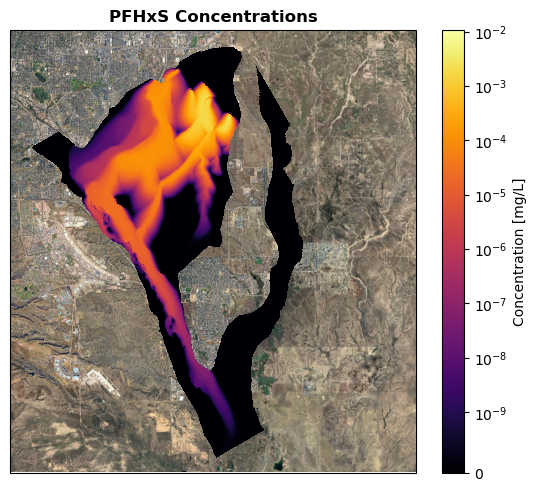

In [58]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfhxs)

# plot PFOS
vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFHxS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFHxS concentration

In [59]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [60]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFHxS (ng/L)"]

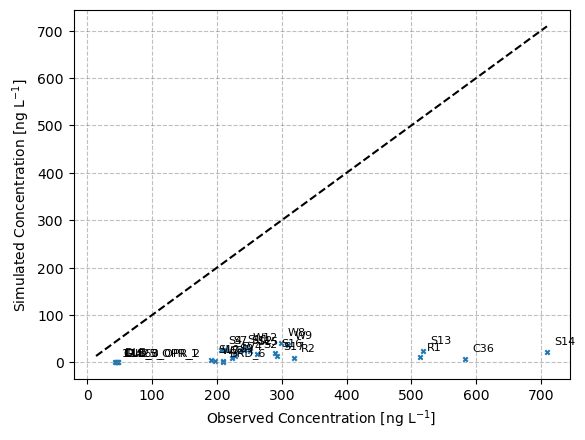

In [61]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, s=10, marker='x')
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [62]:
pfhxs_us = pd.read_csv('../input-files/data-files/tran-PFHxS-observations.csv')

pfhxs_us['SDate'] = pd.to_datetime(pfhxs_us.SDate)

pfhxs_us.set_index('SDate', inplace=True)

In [56]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [57]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [58]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL 1 not in both
Well WELL 3 not in both
Well WELL 4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

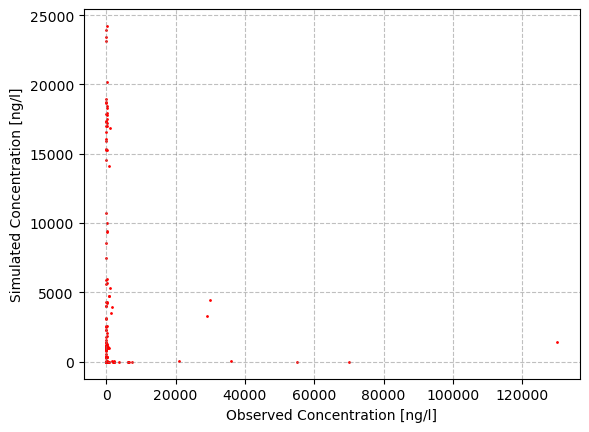

In [59]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfhxs_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

In [60]:
import imageio

In [78]:
# fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
# ax1, ax2, ax3 = axs

# modelmap = fplt.PlotMapView(model=gwt_pfos)

# # plot PFOS
# vmax = PFOS[PFOS != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFOS[0], ax=ax1, cmap='inferno', norm=norm,
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')

# # Plot PFOA
# vmax = PFOA[PFOA != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFOA[0], ax=ax2, cmap='inferno', norm=norm, 
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')

# # Plot PFHxS
# vmax = PFHxS[PFHxS != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFHxS[0], ax=ax3, cmap='inferno', norm=norm, 
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')

# titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
# for ax, title in zip(axs, titles):
#     ggtiles = GoogleTiles(style='satellite')
#     ax.add_image(ggtiles, 13)
    
#     ax.set_title(title, weight='bold')

# plt.show()

In [ ]:
# for i in range(350):
#     fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
#     ax1, ax2, ax3 = axs
    
#     modelmap = fplt.PlotMapView(model=gwt_pfos)
    
#     # plot PFOS
#     vmax = PFOS[PFOS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOS[i][0], ax=ax1, cmap='inferno', norm=norm,
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')
    
#     # Plot PFOA
#     vmax = PFOA[PFOA != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOA[i][0], ax=ax2, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')
    
#     # Plot PFHxS
#     vmax = PFHxS[PFHxS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFHxS[i][0], ax=ax3, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')
    
#     titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
#     for ax, title in zip(axs, titles):
#         ggtiles = GoogleTiles(style='satellite')
#         ax.add_image(ggtiles, 13)
        
#         ax.set_title(title, weight='bold')
    
#     plt.savefig(f'../figures/gif-pngs/sp-{i}.png')
#     plt.close()

# pngs = [imageio.v2.imread(f'../figures/gif-pngs/sp-{i}.png') for i in range(350)]

# imageio.mimsave('../figures/concentrations.gif', pngs, duration=50, loop=0)